In [1]:
%config InlineBackend.figure_formats = ['retina']  # increase resolution on retina screens
import numpy as np
import scanpy as sc
import scipy as sci
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from deap import creator, base, tools, algorithms
from sklearn.svm import NuSVR
import pickle

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


In [2]:
#read single-cell data
file = 'data/GSE75748_sc_cell_type_ec.csv'
adata = sc.read(file, cache=True).transpose()
adata

AnnData object with n_obs × n_vars = 1018 × 19097 

In [3]:
#read 100 synthetic bulks generated by summing single cells
#the bulks are normalized to counts_per_cell_after=1e4
#proportions are only required for validation
path = 'bulks/'
data_bulk_raw = pd.read_csv(path+'bulks.csv',delimiter='\t', index_col=0)
proportions = pd.read_csv(path + "proportions.csv", sep='\t', index_col=0)

In [4]:
#normalizing and selecting 4000 hihgly variable genes for optimization
#we use log normalized data for selecting hihgly variable genes and visualization
adata_norm = sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4, copy=True) 
adata_log = sc.pp.log1p(adata_norm, copy=True) 
sc.pp.highly_variable_genes(adata_log, flavor='cell_ranger', n_top_genes=4000)
adata_proc = adata_norm[:, adata_log.var[adata_log.var['highly_variable']==True].index]
adata_proc

View of AnnData object with n_obs × n_vars = 1018 × 4000 
    obs: 'n_counts'

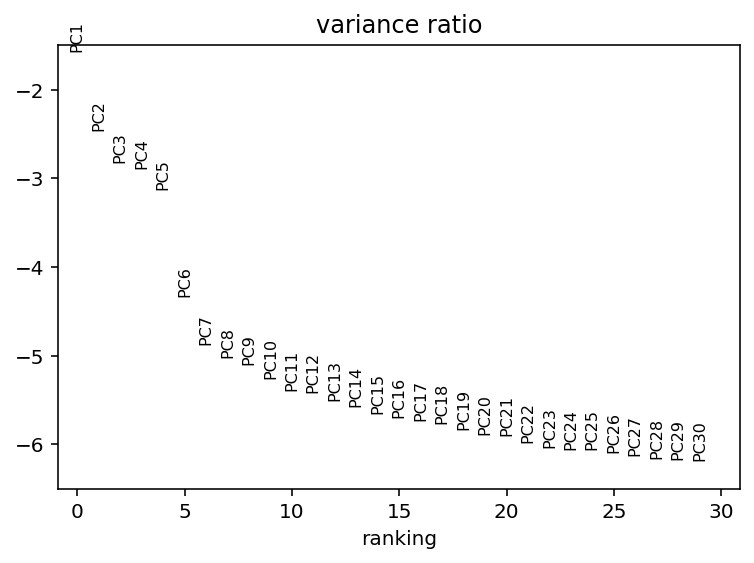

In [5]:
sc.pp.pca(adata_log, n_comps=30, use_highly_variable=True, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata_log, log=True)

In [6]:
adata_log.obs['cells'] = [x.split('_', 1)[0] for x in adata_log.obs_names]

... storing 'cells' as categorical


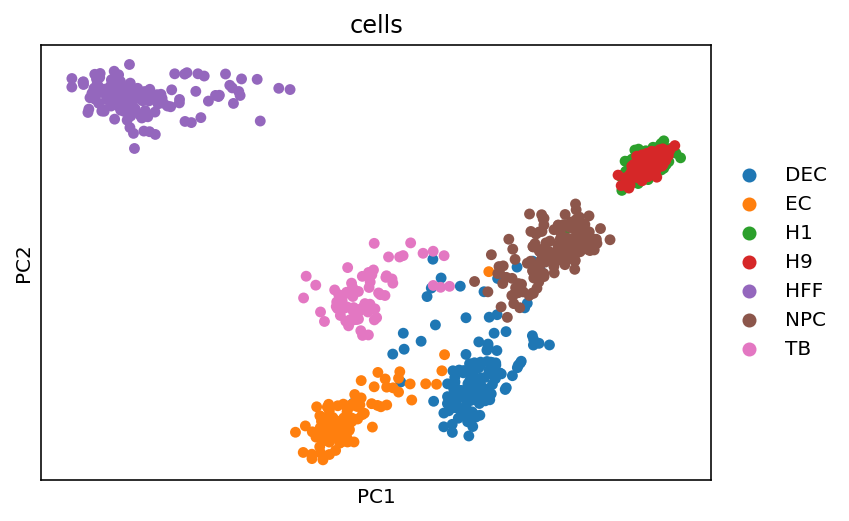

In [7]:
adata_log.obsm['X_pca'] *= -1  # multiply by -1 to match Seurat
sc.pl.pca_scatter(adata_log, color='cells')

In [8]:
#remove H9 because of high correlation with H1
adata_log = adata_log[adata_log.obs[adata_log.obs['cells'] != 'H9'].index]

In [9]:
#filter cells in normalized data
adata_proc = adata_proc[adata_log.obs_names]

In [10]:
#calculating the centroids of cell types
clusters = np.array(['H1', 'DEC', 'EC', 'HFF', 'NPC', 'TB'])
sc_mean = pd.DataFrame(index=adata_proc.var_names,columns=clusters)
for cluster in clusters:
    cells = [x for x in adata_proc.obs_names if x.startswith(cluster)]
    sc_part = adata_proc[cells,:].X.T
    sc_mean[cluster] = pd.DataFrame(np.mean(sc_part,axis=1),index=adata_proc.var_names)
    
centroids_sc_hv = sc_mean
centroids_sc_hv.shape

(4000, 6)

In [11]:
centroids_sc_hv.head()

,H1,DEC,EC,HFF,NPC,TB
CD109,0.155816,0.137496,2.160324,4.340601,0.109122,0.071464
CD163,0.000010,0.089907,0.004771,0.000000,0.000000,0.000000
PHYHIPL,0.004350,0.088457,0.000000,0.000000,0.023976,0.049758
OR9A4,0.000022,0.000000,0.000000,0.000000,0.000092,0.000000
CDH1,1.885752,0.428238,0.160532,0.123398,0.165340,5.422810


In [12]:
isinstance(centroids_sc_hv,pd.DataFrame)

True

In [13]:
isinstance(centroids_sc_hv,np.ndarray)

False

In [14]:
#from autogenes import ga
from autogenes_effectsize import ga

In [15]:
#from autogenes import objectives as ga_objectives
from autogenes_effectsize import objectives as ga_objectives
objectives_func = []
objectives_names = []
objectives = ('correlation','distance')
#objectives = ('distance',)
#objectives =('correlation',)
for f in objectives:
    if callable(f):
        objectives_func.append(f)
        objectives_names.append(f.__name__)
    elif isinstance(f,str):
        if not hasattr(ga_objectives,f):
            raise ValueError(f"No such objective: {f}")
        else:
            objectives_names.append(f)
            objectives_func.append(getattr(ga_objectives,f))
    else:
        raise ValueError("Invalid objective")

    objectives_num = len(objectives_func)
    #self.weights = weights
print(objectives_func)
print(objectives_names)

[<function correlation at 0x13bd34f28>, <function distance at 0x13bd346a8>]
['correlation', 'distance']


In [16]:
my_ga=ga.GeneticAlgorithm(
        data=centroids_sc_hv.T.values, 
        ngen=5,
        mode='fixed',
        weights=(-1.0,1.0), 
        #weights=(-1.0,),
        objectives_names=objectives_names, 
        objectives_func=objectives_func, 
        seed=0, 
        verbose=False,
        nfeatures=4,
        offspring_size= 10
        
        
      )

In [17]:
hof = my_ga.run()

new..............
[[2.5637193e-02 3.7418816e-02 2.3215368e+00 2.6209233e-02]
 [6.2589869e-03 2.8522033e-04 6.6498119e-01 2.1055289e-01]
 [2.7927620e+00 1.4078310e-02 5.2516085e-01 3.9396700e-02]
 [1.5455021e-01 4.6214107e-02 2.9449439e-01 0.0000000e+00]
 [1.2687288e-01 2.1012267e-01 2.3356373e+00 1.8857373e-01]
 [5.0688572e-03 5.9267221e-04 1.7204346e-01 3.2788828e-01]]
new..............
[[2.7069935e-01 6.8108428e-01 5.1171973e-04 2.4291499e-01]
 [2.6513129e-01 7.1974277e-01 9.8565459e-02 4.6270728e-01]
 [2.1381520e-01 5.3981376e-01 0.0000000e+00 6.3379890e-01]
 [5.6871021e-01 9.4027394e-01 0.0000000e+00 4.0995841e+00]
 [3.0311242e-01 9.7469300e-01 3.6858264e-03 8.9263397e-01]
 [3.2074568e+00 6.6392579e+00 0.0000000e+00 1.6958214e+00]]
new..............
[[5.08508742e-01 5.51043488e-02 3.90806096e-03 2.00726688e-01]
 [2.10254407e+00 9.03737545e-02 1.15460843e-01 7.31145591e-02]
 [3.62927222e+00 2.34753147e-01 1.16582885e-02 9.19339418e-01]
 [1.39941378e+01 4.90301400e-01 1.43419495e-02 

new..............
[[0.0000000e+00 4.5104292e-01 1.6375718e-01 7.8882948e-02]
 [1.0488414e-05 1.4550929e+00 4.6908569e-01 5.1451063e-01]
 [0.0000000e+00 7.8318596e-01 5.5745125e+00 2.7305239e-01]
 [0.0000000e+00 2.2620740e+00 5.3515071e-01 1.5369813e-01]
 [2.5639674e-04 3.5937890e-01 4.5107919e-01 1.5572935e-01]
 [0.0000000e+00 1.1890764e+00 1.8093659e+00 4.2879537e-02]]
new..............
[[1.41108612e-04 9.66043591e-01 0.00000000e+00 3.42856139e-01]
 [0.00000000e+00 4.65325505e-01 0.00000000e+00 1.70562363e+00]
 [0.00000000e+00 3.33317757e-01 5.42063324e-04 8.01170707e-01]
 [0.00000000e+00 5.60995378e-02 1.07772707e-04 2.85776877e+00]
 [0.00000000e+00 1.75969350e+00 2.19481044e-05 1.61285833e-01]
 [0.00000000e+00 1.20201916e-01 0.00000000e+00 3.88897285e-02]]
new..............
[[3.1319400e-05 3.7800126e+00 2.4089666e-01 3.9517246e-02]
 [1.4104680e-02 2.2690947e+01 7.3703039e-01 7.5500712e-02]
 [7.0800488e-03 1.0770223e+00 6.1090076e-01 2.2312464e-01]
 [0.0000000e+00 4.8924708e+00 4.885

In [18]:
centroids_sc_pareto = centroids_sc_hv[hof[0]]

In [19]:
centroids_sc_pareto

,H1,DEC,EC,HFF,NPC,TB
DPCR1,0.000224,0.000000,0.000000,0.000000,0.003895,0.000000
SLC2A13,0.060856,0.084773,0.334476,0.016281,0.030167,0.402366
BAG2,0.206625,0.159496,0.042667,1.240271,0.023128,0.046888
PTCHD1,0.112807,0.250896,0.000893,0.000636,0.008631,0.771098


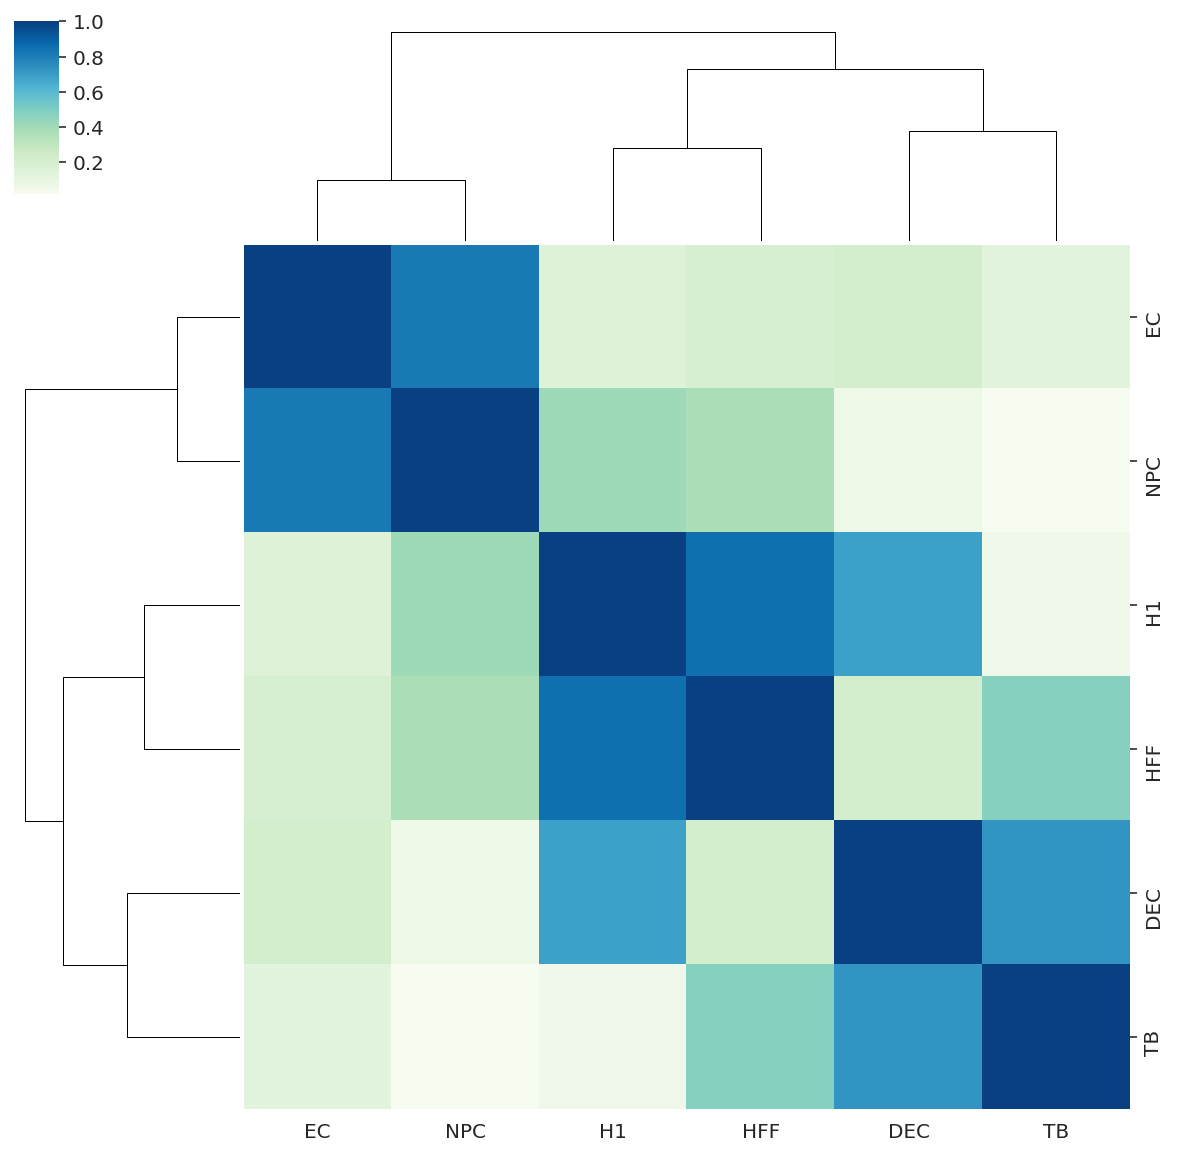

In [20]:
#Correlation matrix
corr = pd.DataFrame(data = np.corrcoef(centroids_sc_pareto.T), columns = centroids_sc_pareto.columns, index = centroids_sc_pareto.columns)
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    sns_plot =sns.clustermap(np.abs(corr),cmap=sns.color_palette("GnBu", 1000), robust=True)

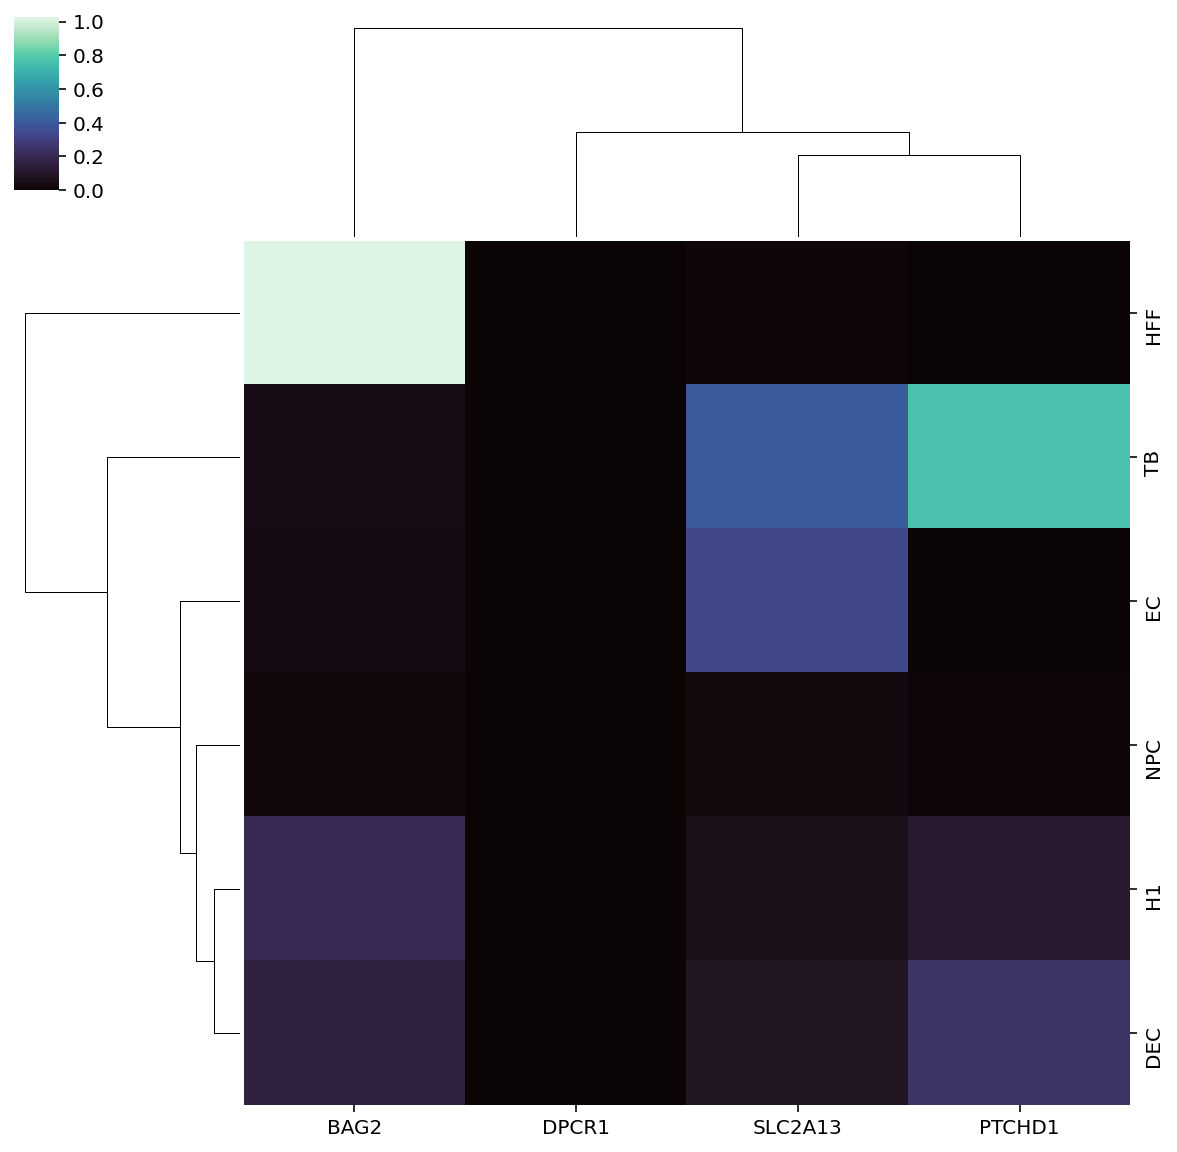

In [21]:
#marker genes
import seaborn as sns
subTypes = pd.DataFrame
subTypes = centroids_sc_pareto.columns
type_pal = sns.husl_palette(centroids_sc_pareto.columns.size, s=0.7)
lut = dict(zip(centroids_sc_pareto.columns.unique(), type_pal))
row_colors = subTypes.map(lut)
sns_plot = sns.clustermap(centroids_sc_pareto.T, cmap="mako", robust=True)

In [22]:
centroids_sc_pareto.shape

(4, 6)

In [23]:
#centroids_sc_pareto.to_csv("centroids_sc_pareto_DEAP_only_corr.csv")